# Interface Reactions

This notebook shows how to
* Obtain information about interface reactions between two solid substances in contact, and
* Plot reaction energy as a function of mixing ratio.

Written using:
- pymatgen==2018.11.6

We use the [Materials Project API](https://github.com/materialsproject/mapidoc) to obtain energies of compounds.

In [1]:
from pymatgen.ext.matproj import MPRester
from pymatgen.analysis.interface_reactions import InterfacialReactivity
from pymatgen.analysis.phase_diagram import PhaseDiagram, GrandPotentialPhaseDiagram
from pymatgen import Composition, Element
%matplotlib inline

# Initialize the REST API interface. You may need to put your own API key in as an arg.
mpr = MPRester()

/Users/yihanxiao/github/pymatgen/pymatgen/__init__.py:89: UserWarning: 
Pymatgen will drop Py2k support from v2019.1.1. Pls consult the documentation
at https://www.pymatgen.org for more details.
  at https://www.pymatgen.org for more details.""")


First, set the values of the two reactants. Optionally, simulate the case where the reaction system is in contact with an elemental reservoir.

Because the methodology here is to generate a pseudo-binary phase stability diagram of two reactants as a function of mixing ratio, the addition of an elemental reservoir implies construction of a so-called _grand potential phase diagram_.

In [2]:
# Chemical formulae for two solid reactants.
reactant1 = 'LiCoO2'
reactant2 = 'Li3PS4'

# Is the system open to an elemental reservoir?
grand = True

if grand:
    # Element in the elemental reservoir.
    open_el = 'Co'
    # Relative chemical potential vs. pure substance. Must be non-positive.
    relative_mu = -1

Now, compile the critical reaction information:

In [3]:
# Get the compositions of the reactants
comp1 = Composition(reactant1)
comp2 = Composition(reactant2)

# Gather all elements involved in the chemical system.
elements = [e.symbol for e in comp1.elements + comp2.elements]
if grand:
    elements.append(open_el)
elements = list(set(elements)) # Remove duplicates

# Get all entries in the chemical system
entries = mpr.get_entries_in_chemsys(elements)

# Build a phase diagram using these entries.
pd = PhaseDiagram(entries)

# For an open system, include the grand potential phase diagram.
if grand:
    # Get the chemical potential of the pure subtance.
    mu = pd.get_transition_chempots(Element(open_el))[0]
    # Set the chemical potential in the elemental reservoir.
    chempots = {open_el: relative_mu + mu}
    # Build the grand potential phase diagram
    gpd = GrandPotentialPhaseDiagram(entries, chempots)
    # Create InterfacialReactivity object.
    interface = InterfacialReactivity(
        comp1, comp2, gpd, norm=True, include_no_mixing_energy=True, pd_non_grand=pd, use_hull_energy=False)
else:
    interface = InterfacialReactivity(
        comp1, comp2, pd, norm=True, include_no_mixing_energy=False, pd_non_grand=None, use_hull_energy=False)

From here, you can plot reaction energy versus mixing ratio as below. Note that the mixing ratio is between the normalized compositions of the reactants.

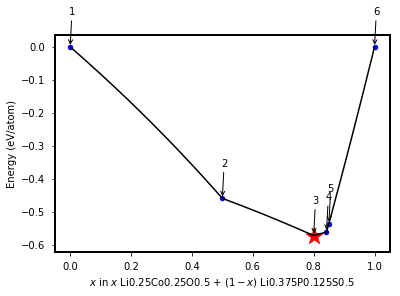

In [4]:
plt = interface.plot()

You can also collect the critical reaction equations at each point:

In [5]:
from collections import OrderedDict
import pandas as pd

critical_rxns = [
    OrderedDict([
        ("mixing ratio", round(ratio, 3)),
        ("reactivity (eV/atom)", round(reactivity, 3)),
        ("reaction", rxn),
        ("reaction energy (kJ/mol)", round(rxn_energy))
    ])
    for _, ratio, reactivity, rxn, rxn_energy in interface.get_kinks()]
interface_reaction_table = pd.DataFrame(critical_rxns)
interface_reaction_table

,mixing ratio,reactivity (eV/atom),reaction,reaction energy (kJ/mol)
0,0.000,0.000,Li3PS4 -> Li3PS4,0.0
1,0.500,-0.458,Li3PS4 + 2 LiCoO2 -> 0.5 Co + Li2S + 1.5 CoS2 ...,-619.0
2,0.800,-0.571,Li3PS4 + 8 LiCoO2 -> 8 Co + Li2S + 3 Li2SO4 + ...,-1763.0
3,0.842,-0.560,Li3PS4 + 10.67 LiCoO2 -> 10.67 Co + 4 Li2SO4 +...,-2162.0
4,0.850,-0.535,Li3PS4 + 11.33 LiCoO2 -> 10.67 Co + 0.6667 Li5...,-2168.0
5,1.000,-0.000,LiCoO2 -> LiCoO2,-0.0


You can also obtain the mixing ratio between the original compositions, i.e. mol fraction of the first reactant.

In [6]:
import numpy as np
interface_reaction_table['Mol Fraction'] = pd.Series(np.round(interface.get_critical_original_kink_ratio(), 3))
interface_reaction_table

,mixing ratio,reactivity (eV/atom),reaction,reaction energy (kJ/mol),Mol Fraction
0,0.000,0.000,Li3PS4 -> Li3PS4,0.0,0.000
1,0.500,-0.458,Li3PS4 + 2 LiCoO2 -> 0.5 Co + Li2S + 1.5 CoS2 ...,-619.0,0.667
2,0.800,-0.571,Li3PS4 + 8 LiCoO2 -> 8 Co + Li2S + 3 Li2SO4 + ...,-1763.0,0.889
3,0.842,-0.560,Li3PS4 + 10.67 LiCoO2 -> 10.67 Co + 4 Li2SO4 +...,-2162.0,0.914
4,0.850,-0.535,Li3PS4 + 11.33 LiCoO2 -> 10.67 Co + 0.6667 Li5...,-2168.0,0.919
5,1.000,-0.000,LiCoO2 -> LiCoO2,-0.0,1.000


Note that the reaction equations are `Reaction` objects suitable for structured analysis:

In [7]:
rxn = critical_rxns[2]["reaction"]
print(rxn)
print(type(rxn))

Li3PS4 + 8 LiCoO2 -> 8 Co + Li2S + 3 Li2SO4 + Li3PO4
<class 'pymatgen.analysis.reaction_calculator.Reaction'>


Now, the REST API interface provides a shortcut to obtain reaction information in a list of map.

In [8]:
# Get interface reaction information for reactants LiCoO2 and Li3PS4 in open system to Co.
kinks_from_API = mpr.get_interface_reactions('LiCoO2','Li3PS4', open_el='Co', relative_mu=-1, use_hull_energy=False)

# Get inforamtion for the second critical reaction.
print(kinks_from_API[1])

{u'energy_per_mol_rxn_kJmol': -619.1697988675436, u'rxn': Li3PS4 + 2 LiCoO2 -> 0.5 Co + Li2S + 1.5 CoS2 + Li3PO4, u'energy': -0.45837463535714296, u'rxn_str': u'Li3PS4 + 2 LiCoO2 -> 0.5 Co + Li2S + 1.5 CoS2 + Li3PO4', u'ratio': 0.6666666666666665, u'rxn_energy_sigdig_kJmol': u'-619.2', u'rxn_energy_sigdig': u'-0.4584'}


The critical reaction information from REST API should be the same as in the previous table:

In [9]:
critical_rxns_from_API = [
    OrderedDict([
        ("Mol Fraction", round(reaction['ratio'], 3)),
        ("reactivity (eV/atom)", round(reaction['energy'], 3)),
        ("reaction", reaction['rxn_str']),
        ("reaction energy (kJ/mol)", round(float(reaction['rxn_energy_sigdig_kJmol'])))
    ])
    for reaction in kinks_from_API]
pd.DataFrame(critical_rxns_from_API)

,Mol Fraction,reactivity (eV/atom),reaction,reaction energy (kJ/mol)
0,0.000,0.000,Li3PS4 -> Li3PS4,0.0
1,0.667,-0.458,Li3PS4 + 2 LiCoO2 -> 0.5 Co + Li2S + 1.5 CoS2 ...,-619.0
2,0.889,-0.571,Li3PS4 + 8 LiCoO2 -> 8 Co + 3 Li2SO4 + Li2S + ...,-1763.0
3,0.914,-0.560,Li3PS4 + 10.67 LiCoO2 -> 10.67 Co + 1.333 Li2O...,-2162.0
4,0.919,-0.535,Li3PS4 + 11.33 LiCoO2 -> 10.67 Co + 0.6667 Li5...,-2168.0
5,1.000,-0.000,LiCoO2 -> LiCoO2,-0.0
